<a href="https://colab.research.google.com/github/adyab1/AI-Based-Control-System-for-Fault-Detection-and-Management-of-Charging-Stations/blob/main/notebooks/EVAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data collation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define number of stations and data points
num_stations = 5
data_points_per_station = 1000  # e.g., 1000 time intervals

# Define station types (e.g., different power ratings)
station_types = {
    'Type_A': {'voltage_AC': 230, 'voltage_DC': 400, 'current_AC': 32, 'current_DC': 125},
    'Type_B': {'voltage_AC': 230, 'voltage_DC': 500, 'current_AC': 32, 'current_DC': 150},
    'Type_C': {'voltage_AC': 400, 'voltage_DC': 800, 'current_AC': 63, 'current_DC': 200},
    'Type_D': {'voltage_AC': 400, 'voltage_DC': 1000, 'current_AC': 63, 'current_DC': 250},
    'Type_E': {'voltage_AC': 230, 'voltage_DC': 300, 'current_AC': 16, 'current_DC': 80},
}

In [ ]:
def simulate_electrical_data(station_specs, size):
    voltage_AC = np.random.normal(loc=station_specs['voltage_AC'], scale=5, size=size)
    voltage_DC = np.random.normal(loc=station_specs['voltage_DC'], scale=10, size=size)
    current_AC = np.random.normal(loc=station_specs['current_AC'], scale=1, size=size)
    current_DC = np.random.normal(loc=station_specs['current_DC'], scale=5, size=size)
    power_factor = np.clip(np.random.normal(loc=0.95, scale=0.02, size=size), 0.8, 1.0)
    return voltage_AC, voltage_DC, current_AC, current_DC, power_factor

def simulate_power_quality(size):
    THD = np.clip(np.random.normal(loc=5, scale=1, size=size), 0, 10)  # Total Harmonic Distortion (%)
    voltage_sags = np.random.binomial(1, 0.01, size=size)  # 1 indicates sag
    voltage_swells = np.random.binomial(1, 0.01, size=size)  # 1 indicates swell
    transients = np.random.binomial(1, 0.005, size=size)  # 1 indicates transient
    return THD, voltage_sags, voltage_swells, transients

def simulate_thermal_data(station_specs, size):
    transformer_temp = np.random.normal(loc=70, scale=5, size=size)  # Degrees Celsius
    cable_temp = np.random.normal(loc=50, scale=3, size=size)  # Degrees Celsius
    return transformer_temp, cable_temp

def simulate_usage_data(size):
    charging_session = np.random.binomial(1, 0.3, size=size)  # 1 indicates active session
    session_start_time = np.random.uniform(0, 24, size=size)  # Hours in a day
    session_duration = np.where(charging_session == 1, np.random.uniform(0.5, 3, size=size), 0)  # Hours
    energy_delivered = session_duration * np.random.uniform(10, 50, size=size)  # kWh
    return charging_session, session_start_time, session_duration, energy_delivered

# Create a dictionary to hold data for all stations
all_station_data = {}

for station_id, (station_type, specs) in enumerate(station_types.items(), start=1):
    # Simulate data
    voltage_AC, voltage_DC, current_AC, current_DC, power_factor = simulate_electrical_data(specs, data_points_per_station)
    THD, voltage_sags, voltage_swells, transients = simulate_power_quality(data_points_per_station)
    transformer_temp, cable_temp = simulate_thermal_data(specs, data_points_per_station)
    charging_session, session_start_time, session_duration, energy_delivered = simulate_usage_data(data_points_per_station)

    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': pd.date_range(start='2023-01-01', periods=data_points_per_station, freq='T'),
        'station_id': station_id,
        'station_type': station_type,
        'voltage_AC': voltage_AC,
        'voltage_DC': voltage_DC,
        'current_AC': current_AC,
        'current_DC': current_DC,
        'power_factor': power_factor,
        'THD': THD,
        'voltage_sag': voltage_sags,
        'voltage_swell': voltage_swells,
        'transient': transients,
        'transformer_temp': transformer_temp,
        'cable_temp': cable_temp,
        'charging_session': charging_session,
        'session_start_time': session_start_time,
        'session_duration': session_duration,
        'energy_delivered': energy_delivered
    })

    # Introduce some missing values randomly (1% per column)
    for col in df.columns:
        df.loc[df.sample(frac=0.01).index, col] = np.nan

    all_station_data[station_id] = df

<ipython-input-2-a3d1450311dc>:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=data_points_per_station, freq='T'),
<ipython-input-2-a3d1450311dc>:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=data_points_per_station, freq='T'),
<ipython-input-2-a3d1450311dc>:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=data_points_per_station, freq='T'),
<ipython-input-2-a3d1450311dc>:40: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=data_points_per_station, freq='T'),
<ipython-input-2-a3d1450311dc>:40: FutureWarning: 'T' is deprecated and will be removed 

In [ ]:
# Create a directory to store CSV files
os.makedirs('ev_charging_data', exist_ok=True)

# Save each station's data as a separate CSV file
for station_id, df in all_station_data.items():
    filename = f'ev_charging_data/station_{station_id}.csv'
    df.to_csv(filename, index=False)

print("Data collation completed and CSV files saved.")



Data collation completed and CSV files saved.


#Data processing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# List of CSV files
csv_files = [f'ev_charging_data/station_{i}.csv' for i in range(1, num_stations + 1)]

# Load all data into a single DataFrame
df_list = []
for file in csv_files:
    df = pd.read_csv(file, parse_dates=['timestamp'])
    df_list.append(df)

# Concatenate all station data
data = pd.concat(df_list, ignore_index=True)

# Check for missing values
print("\nMissing values before imputation:")
print(data.isnull().sum())

# Impute numerical columns with median
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    median = data[col].median()
    data[col].fillna(median, inplace=True)

# For categorical columns, fill missing with mode
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if col != 'timestamp':  # 'timestamp' is datetime, handled separately
        mode = data[col].mode()[0]
        data[col].fillna(mode, inplace=True)

# Handle missing 'timestamp' separately if any
if data['timestamp'].isnull().sum() > 0:
    # Option 1: Drop rows with missing timestamp
    data.dropna(subset=['timestamp'], inplace=True)
    print("\nDropped rows with missing timestamps.")

# Verify no missing values remain
print("\nMissing values after imputation:")
print(data.isnull().sum())



Missing values before imputation:
timestamp             50
station_id            50
station_type          50
voltage_AC            50
voltage_DC            50
current_AC            50
current_DC            50
power_factor          50
THD                   50
voltage_sag           50
voltage_swell         50
transient             50
transformer_temp      50
cable_temp            50
charging_session      50
session_start_time    50
session_duration      50
energy_delivered      50
dtype: int64

Dropped rows with missing timestamps.

Missing values after imputation:
timestamp             0
station_id            0
station_type          0
voltage_AC            0
voltage_DC            0
current_AC            0
current_DC            0
power_factor          0
THD                   0
voltage_sag           0
voltage_swell         0
transient             0
transformer_temp      0
cable_temp            0
charging_session      0
session_start_time    0
session_duration      0
energy_delivered     

<ipython-input-4-5f69535f495a>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median, inplace=True)
<ipython-input-4-5f69535f495a>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

In [ ]:
# Normalize the data
scaler = MinMaxScaler()

# Select columns to normalize
cols_to_normalize = [
    'voltage_AC', 'voltage_DC', 'current_AC', 'current_DC',
    'power_factor', 'THD', 'transformer_temp',
    'cable_temp', 'session_start_time',
    'session_duration', 'energy_delivered'
]

# Ensure all columns to normalize exist
missing_cols = set(cols_to_normalize) - set(data.columns)
if missing_cols:
    print(f"Warning: The following columns are missing and cannot be normalized: {missing_cols}")

# Apply scaling
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

# Display normalized data
print("\nNormalized data preview:")
print(data.head())



Normalized data preview:
            timestamp  station_id station_type  voltage_AC  voltage_DC  \
0 2023-01-01 00:00:00         1.0       Type_A    0.101941    0.185374   
1 2023-01-01 00:01:00         1.0       Type_A    0.086472    0.179175   
2 2023-01-01 00:02:00         1.0       Type_A    0.105618    0.167880   
3 2023-01-01 00:03:00         1.0       Type_A    0.126942    0.158653   
4 2023-01-01 00:04:00         1.0       Type_A    0.084137    0.297599   

   current_AC  current_DC  power_factor       THD  voltage_sag  voltage_swell  \
0    0.352278    0.252612      0.407492  0.424017          0.0            0.0   
1    0.362101    0.278968      0.554107  0.419867          0.0            0.0   
2    0.350108    0.290211      0.562777  0.232011          0.0            0.0   
3    0.359076    0.348119      0.642861  0.437127          0.0            0.0   
4    0.329723    0.314623      0.318820  0.585892          0.0            1.0   

   transient  transformer_temp  cable_temp

#Feature Engineering

In [ ]:
# Sort data by station and timestamp
data = data.sort_values(by=['station_id', 'timestamp']).reset_index(drop=True)

# Define rolling window size (e.g., last 10 minutes)
window_size = 10

# Create rolling features for electrical parameters
rolling_features = ['voltage_AC', 'voltage_DC', 'current_AC', 'current_DC', 'power_factor']
for feature in rolling_features:
    data[f'{feature}_ma'] = data.groupby('station_id')[feature].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    data[f'{feature}_std'] = data.groupby('station_id')[feature].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())

# Similarly, create rolling features for thermal data
thermal_features = ['transformer_temp', 'cable_temp']
for feature in thermal_features:
    data[f'{feature}_ma'] = data.groupby('station_id')[feature].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    data[f'{feature}_std'] = data.groupby('station_id')[feature].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())

# After rolling, check for any NaNs introduced (should be none with min_periods=1)
print("\nMissing values after rolling feature creation:")
print(data.isnull().sum())

# If any NaNs exist, handle them
if data.isnull().sum().any():
    print("\nHandling residual NaNs after rolling features.")
    data.fillna(0, inplace=True)  # Example: Fill NaNs with 0
    print("Residual NaNs filled with 0.")
else:
    print("\nNo residual NaNs after rolling feature creation.")



Missing values after rolling feature creation:
timestamp               0
station_id              0
station_type            0
voltage_AC              0
voltage_DC              0
current_AC              0
current_DC              0
power_factor            0
THD                     0
voltage_sag             0
voltage_swell           0
transient               0
transformer_temp        0
cable_temp              0
charging_session        0
session_start_time      0
session_duration        0
energy_delivered        0
voltage_AC_ma           0
voltage_AC_std          5
voltage_DC_ma           0
voltage_DC_std          5
current_AC_ma           0
current_AC_std          5
current_DC_ma           0
current_DC_std          5
power_factor_ma         0
power_factor_std        5
transformer_temp_ma     0
transformer_temp_std    5
cable_temp_ma           0
cable_temp_std          5
dtype: int64

Handling residual NaNs after rolling features.
Residual NaNs filled with 0.


In [ ]:
# Example: Calculate Power (P = V * I * Power Factor)
data['power_AC'] = data['voltage_AC'] * data['current_AC'] * data['power_factor']
data['power_DC'] = data['voltage_DC'] * data['current_DC']  # DC power doesn't involve power factor

# Example: Energy efficiency (Energy delivered / Power)
data['efficiency_AC'] = data['energy_delivered'] / (data['power_AC'] + 1e-6)  # Avoid division by zero
data['efficiency_DC'] = data['energy_delivered'] / (data['power_DC'] + 1e-6)

# Example: Temperature gradients
data['transformer_temp_grad'] = data.groupby('station_id')['transformer_temp'].diff().fillna(0)
data['cable_temp_grad'] = data.groupby('station_id')['cable_temp'].diff().fillna(0)

# Display data with domain-specific features
print("\nData with domain-specific features:")
print(data.head())


Data with domain-specific features:
            timestamp  station_id station_type  voltage_AC  voltage_DC  \
0 2023-01-01 00:00:00         1.0       Type_A    0.101941    0.185374   
1 2023-01-01 00:01:00         1.0       Type_A    0.086472    0.179175   
2 2023-01-01 00:02:00         1.0       Type_A    0.105618    0.167880   
3 2023-01-01 00:03:00         1.0       Type_A    0.126942    0.158653   
4 2023-01-01 00:04:00         1.0       Type_A    0.084137    0.297599   

   current_AC  current_DC  power_factor       THD  voltage_sag  ...  \
0    0.352278    0.252612      0.407492  0.424017          0.0  ...   
1    0.362101    0.278968      0.554107  0.419867          0.0  ...   
2    0.350108    0.290211      0.562777  0.232011          0.0  ...   
3    0.359076    0.348119      0.642861  0.437127          0.0  ...   
4    0.329723    0.314623      0.318820  0.585892          0.0  ...   

   transformer_temp_ma  transformer_temp_std  cable_temp_ma  cable_temp_std  \
0           

#Data Integration

In [ ]:
# Ensure station_id is treated as a categorical variable
data['station_id'] = data['station_id'].astype('category')

# Display the integrated data structure
print("\nIntegrated DataFrame Info:")
print(data.info())

# Save integrated data to CSV (optional)
data.to_csv('ev_charging_integrated_data.csv', index=False)
print("\nIntegrated data saved to 'ev_charging_integrated_data.csv'.")



Integrated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              4950 non-null   datetime64[ns]
 1   station_id             4950 non-null   category      
 2   station_type           4950 non-null   object        
 3   voltage_AC             4950 non-null   float64       
 4   voltage_DC             4950 non-null   float64       
 5   current_AC             4950 non-null   float64       
 6   current_DC             4950 non-null   float64       
 7   power_factor           4950 non-null   float64       
 8   THD                    4950 non-null   float64       
 9   voltage_sag            4950 non-null   float64       
 10  voltage_swell          4950 non-null   float64       
 11  transient              4950 non-null   float64       
 12  transformer_temp       4950 non-nu

#Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define target variable for fault detection
# For simulation, let's assume 'fault' occurs when voltage_sag, voltage_swell, or transient is 1
data['fault'] = ((data['voltage_sag'] == 1) |
                (data['voltage_swell'] == 1) |
                (data['transient'] == 1)).astype(int)

# Features to consider (excluding timestamp, station_id, station_type, and target variable)
feature_cols = data.columns.drop(['timestamp', 'station_id', 'station_type', 'fault'])

X = data[feature_cols]
y = data['fault']

# Check for any remaining NaNs in X
if X.isnull().sum().any():
    print("\nHandling NaNs in features before feature selection.")
    # Example: Fill NaNs with 0
    X.fillna(0, inplace=True)
    print("NaNs in features filled with 0.")
else:
    print("\nNo NaNs in features before feature selection.")

# Select top 20 features using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=20)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support(indices=True)]
print("\nSelected Features:", selected_features.tolist())

# Update X to include only selected features
X = X[selected_features]


No NaNs in features before feature selection.

Selected Features: ['current_DC', 'THD', 'voltage_sag', 'voltage_swell', 'transient', 'transformer_temp', 'charging_session', 'session_start_time', 'session_duration', 'energy_delivered', 'voltage_AC_std', 'voltage_DC_std', 'current_AC_std', 'current_DC_ma', 'power_factor_ma', 'power_factor_std', 'transformer_temp_std', 'cable_temp_ma', 'efficiency_DC', 'cable_temp_grad']


#Fault Type Assignment

In [ ]:
def assign_fault_type(row):
    faults = []
    if row['voltage_sag'] == 1:
        faults.append('Voltage_Sag')
    if row['voltage_swell'] == 1:
        faults.append('Voltage_Swell')
    if row['transient'] == 1:
        faults.append('Transient')
    if len(faults) == 0:
        return 'No_Fault'
    elif len(faults) == 1:
        return faults[0]
    else:
        return 'Multiple_Faults'

data['fault_type'] = data.apply(assign_fault_type, axis=1)

# Encode fault_type
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['fault_type_encoded'] = le.fit_transform(data['fault_type'])

# Display the distribution
print("\nFault Type Distribution:")
print(data['fault_type'].value_counts())

# Check for consistency in fault_type
print("\nUnique Fault Types:", data['fault_type'].unique())


Fault Type Distribution:
fault_type
No_Fault           4849
Voltage_Sag          43
Voltage_Swell        42
Transient            14
Multiple_Faults       2
Name: count, dtype: int64

Unique Fault Types: ['No_Fault' 'Voltage_Swell' 'Voltage_Sag' 'Transient' 'Multiple_Faults']


#Handling Fault Classification Feature Selection

In [ ]:
feature_cols_classification = data.columns.drop(['timestamp', 'station_id', 'station_type', 'fault', 'fault_type', 'fault_type_encoded'])

X_classification = data[feature_cols_classification]
y_classification = data['fault_type_encoded']

# Handle any remaining missing values (if any)
if X_classification.isnull().sum().any():
    print("\nHandling NaNs in classification features.")
    X_classification.fillna(0, inplace=True)
    print("NaNs in classification features filled with 0.")
else:
    print("\nNo NaNs in classification features.")

# Feature Selection using SelectKBest
selector_classification = SelectKBest(score_func=f_classif, k=20)
X_classification_new = selector_classification.fit_transform(X_classification, y_classification)

# Get selected feature names
selected_features_classification = X_classification.columns[selector_classification.get_support(indices=True)]
print("\nSelected Features for Classification:", selected_features_classification.tolist())

# Update X_classification to include only selected features
X_classification = X_classification[selected_features_classification]


No NaNs in classification features.

Selected Features for Classification: ['voltage_AC', 'voltage_DC', 'current_AC', 'voltage_sag', 'voltage_swell', 'transient', 'charging_session', 'session_start_time', 'session_duration', 'energy_delivered', 'voltage_AC_ma', 'voltage_AC_std', 'voltage_DC_std', 'current_AC_std', 'current_DC_std', 'power_factor_std', 'transformer_temp_ma', 'cable_temp_std', 'power_DC', 'efficiency_DC']


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


#Main


##Data


In [ ]:
import pandas as pd
import numpy as np

# Assuming 'data' is the integrated DataFrame from previous steps

# Define normal data: fault == 0
normal_data = data[data['fault'] == 0]

# Define anomalous data: fault == 1
anomalous_data = data[data['fault'] == 1]

print(f"Normal data points: {normal_data.shape[0]}")
print(f"Anomalous data points: {anomalous_data.shape[0]}")


Normal data points: 4849
Anomalous data points: 101


In [ ]:
# Features for the autoencoder (excluding identifiers and target)
features = X.columns  # 'X' is the feature set from feature selection for fault detection

X_normal = normal_data[features].values
X_anomalous = anomalous_data[features].values

print(f"Shape of normal data: {X_normal.shape}")
print(f"Shape of anomalous data: {X_anomalous.shape}")


Shape of normal data: (4849, 20)
Shape of anomalous data: (101, 20)


##Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the size of the input
input_dim = X_normal.shape[1]  # 20 features

# Define the Autoencoder architecture
encoding_dim = 14  # Can be tuned based on experimentation

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │             294 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 615 (2.40 KB)

 Trainable params: 615 (2.40 KB)

 Non-trainable params: 0 (0.00 B)

##Training Autoencoder

In [ ]:
from sklearn.model_selection import train_test_split

# Split normal data into training and validation sets
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# Train the Autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1
)


Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 233.5455 - val_loss: 115.6006
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 950.7850 - val_loss: 101.0757
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 485.5396 - val_loss: 86.6042
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 199.1362 - val_loss: 71.8059
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 317.3337 - val_loss: 57.8251
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 466.3043 - val_loss: 30.4478
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 75.3709 - val_loss: 7.9776
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.2891 - val_loss: 2.7906
Epoch 9/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 47.3415 - val_loss: 0.7886
Epoch 10/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7543 - val_loss: 0.2465
Epoch 11/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1654 - val_loss: 0.0676
Epoch 12/50
122/122 ━━━━━━━━

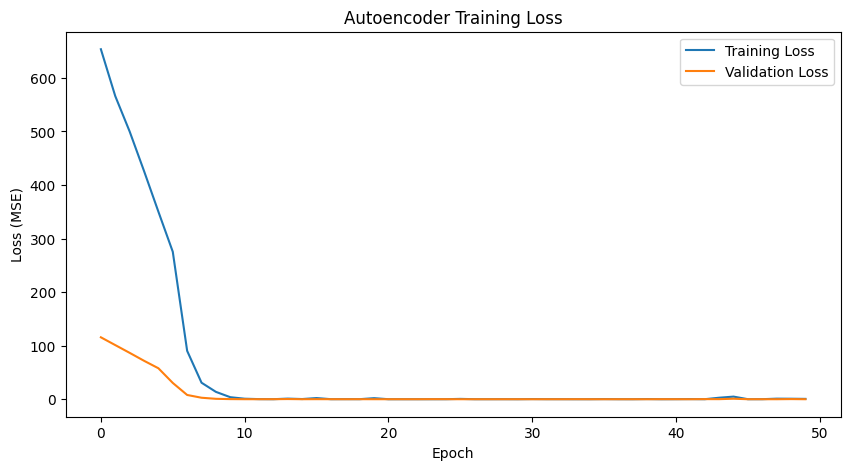

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.show()


##Detecting Anomalies

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


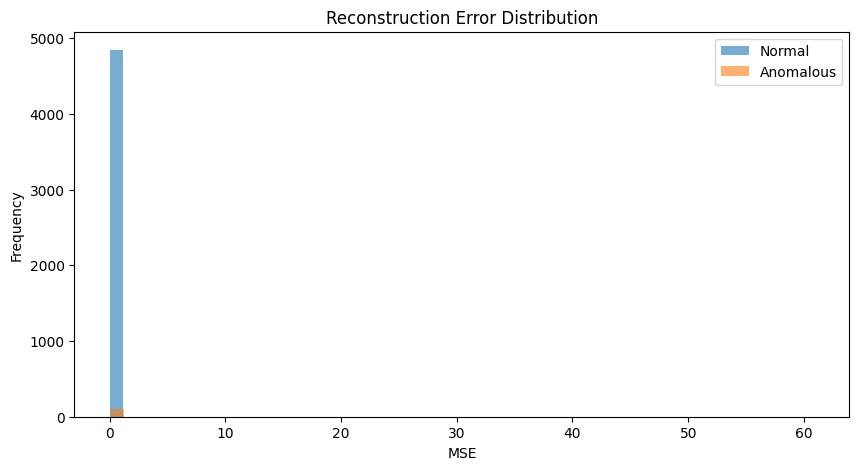

Reconstruction error threshold: 0.11866396123948121
Normal data - Predicted Anomalies: 243 out of 4849
Anomalous data - Detected Anomalies: 10 out of 101


In [ ]:
# Reconstruction error on normal data
X_normal_pred = autoencoder.predict(X_normal)
mse_normal = np.mean(np.power(X_normal - X_normal_pred, 2), axis=1)

# Reconstruction error on anomalous data
X_anomalous_pred = autoencoder.predict(X_anomalous)
mse_anomalous = np.mean(np.power(X_anomalous - X_anomalous_pred, 2), axis=1)

# Plotting the reconstruction errors
plt.figure(figsize=(10,5))
plt.hist(mse_normal, bins=50, alpha=0.6, label='Normal')
plt.hist(mse_anomalous, bins=50, alpha=0.6, label='Anomalous')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

# Setting threshold (e.g., 95th percentile of normal MSE)
threshold = np.percentile(mse_normal, 95)
print(f"Reconstruction error threshold: {threshold}")

# Predict anomalies based on threshold
y_pred_normal = mse_normal > threshold
y_pred_anomalous = mse_anomalous > threshold

print(f"Normal data - Predicted Anomalies: {np.sum(y_pred_normal)} out of {len(y_pred_normal)}")
print(f"Anomalous data - Detected Anomalies: {np.sum(y_pred_anomalous)} out of {len(y_pred_anomalous)}")


##Identifying contributing Features

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


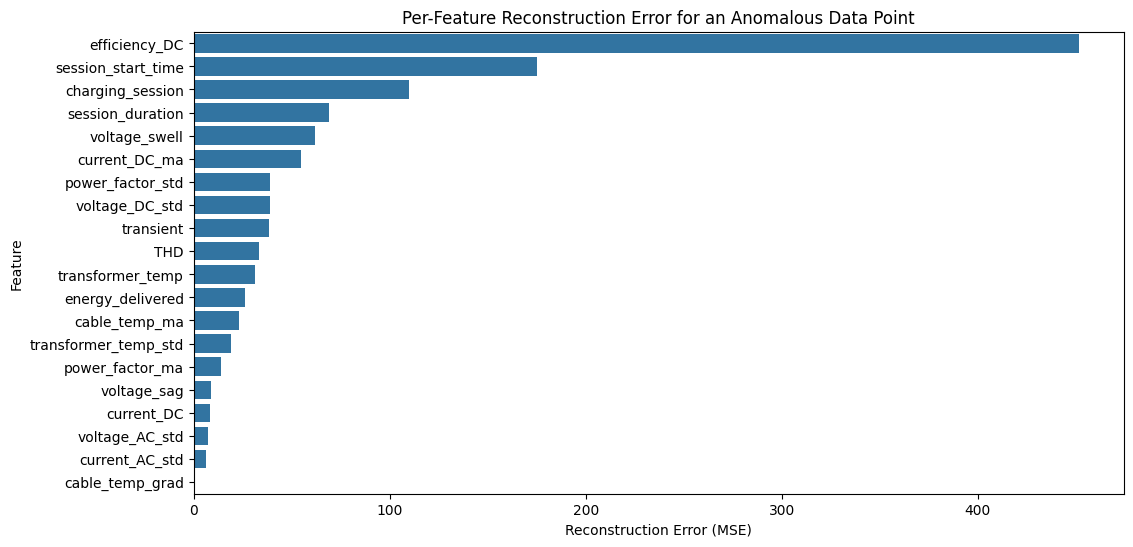

In [ ]:
import seaborn as sns

# Function to calculate per-feature reconstruction error
def feature_reconstruction_error(original, reconstructed):
    return np.power(original - reconstructed, 2)

# Select a sample anomalous data point
sample_index = np.argmax(mse_anomalous)  # Data point with highest reconstruction error
sample_anomaly = X_anomalous[sample_index].reshape(1, -1)
sample_pred = autoencoder.predict(sample_anomaly)
recon_error = feature_reconstruction_error(sample_anomaly, sample_pred).flatten()

# Create a DataFrame for visualization
error_df = pd.DataFrame({
    'Feature': features,
    'Reconstruction_Error': recon_error
}).sort_values(by='Reconstruction_Error', ascending=False)

# Plot the reconstruction errors
plt.figure(figsize=(12,6))
sns.barplot(x='Reconstruction_Error', y='Feature', data=error_df)
plt.title('Per-Feature Reconstruction Error for an Anomalous Data Point')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Feature')
plt.show()


#END

##Fault Classification

In [ ]:
# ==========================
# Fault Classification Model
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming 'data' is your integrated DataFrame from previous steps

# Create multi-class fault labels
# 0: No Fault
# 1: Voltage Sag
# 2: Voltage Swell
# 3: Transient
# 4: Multiple Faults

def assign_fault_type(row):
    faults = []
    if row['voltage_sag'] == 1:
        faults.append('Voltage_Sag')
    if row['voltage_swell'] == 1:
        faults.append('Voltage_Swell')
    if row['transient'] == 1:
        faults.append('Transient')
    if len(faults) == 0:
        return 'No_Fault'
    elif len(faults) == 1:
        return faults[0]
    else:
        return 'Multiple_Faults'

data['fault_type'] = data.apply(assign_fault_type, axis=1)

# Encode fault_type
le = LabelEncoder()
data['fault_type_encoded'] = le.fit_transform(data['fault_type'])

# Display the distribution
print("\nFault Type Distribution:")
print(data['fault_type'].value_counts())



Fault Type Distribution:
fault_type
No_Fault           4849
Voltage_Sag          43
Voltage_Swell        42
Transient            14
Multiple_Faults       2
Name: count, dtype: int64


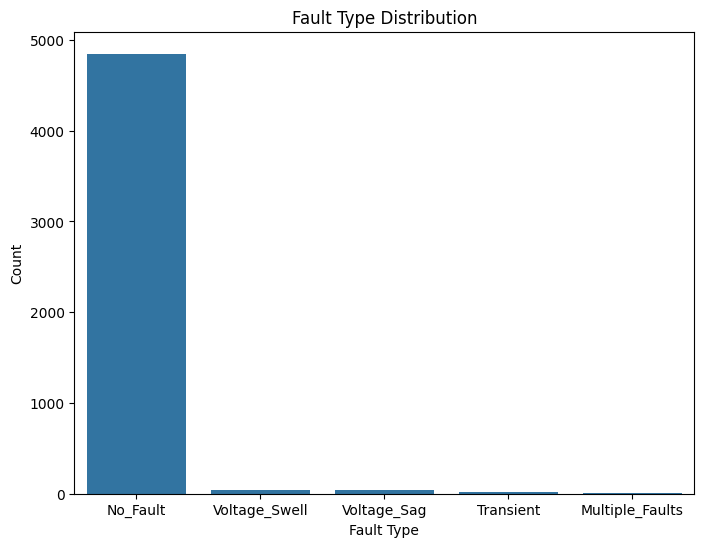

In [ ]:
# Visualize fault type distribution
plt.figure(figsize=(8,6))
sns.countplot(x='fault_type', data=data)
plt.title('Fault Type Distribution')
plt.xlabel('Fault Type')
plt.ylabel('Count')
plt.show()


In [ ]:
# Define features and target for classification
# Exclude 'timestamp', 'station_id', 'station_type', 'fault', 'fault_type', 'fault_type_encoded'
feature_cols_classification = data.columns.drop(['timestamp', 'station_id', 'station_type', 'fault', 'fault_type', 'fault_type_encoded'])

X_classification = data[feature_cols_classification]
y_classification = data['fault_type_encoded']

# Handle any remaining missing values (if any)
if X_classification.isnull().sum().any():
    print("\nHandling NaNs in classification features.")
    X_classification.fillna(0, inplace=True)
    print("NaNs in classification features filled with 0.")
else:
    print("\nNo NaNs in classification features.")

# Feature Selection using SelectKBest for classification
selector_classification = SelectKBest(score_func=f_classif, k=20)
X_classification_new = selector_classification.fit_transform(X_classification, y_classification)

# Get selected feature names
selected_features_classification = X_classification.columns[selector_classification.get_support(indices=True)]
print("\nSelected Features for Classification:", selected_features_classification.tolist())

# Update X_classification to include only selected features
X_classification = X_classification[selected_features_classification]



No NaNs in classification features.

Selected Features for Classification: ['voltage_AC', 'voltage_DC', 'current_AC', 'voltage_sag', 'voltage_swell', 'transient', 'charging_session', 'session_start_time', 'session_duration', 'energy_delivered', 'voltage_AC_ma', 'voltage_AC_std', 'voltage_DC_std', 'current_AC_std', 'current_DC_std', 'power_factor_std', 'transformer_temp_ma', 'cable_temp_std', 'power_DC', 'efficiency_DC']


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [ ]:
# Split data into training and testing sets
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification, test_size=0.2, stratify=y_classification, random_state=42
)

print(f"\nTraining set size: {X_train_clf.shape[0]}")
print(f"Test set size: {X_test_clf.shape[0]}")



Training set size: 3960
Test set size: 990


In [ ]:
# Initialize the classifier with class weighting to handle imbalanced classes
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

# Train the model
rf_classifier.fit(X_train_clf, y_train_clf)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Make predictions
y_pred_clf = rf_classifier.predict(X_test_clf)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_clf))

print("\nClassification Report:")
# Identify the unique classes present in the test set
unique_labels = np.unique(y_test_clf)
# Get corresponding class names
target_names = le.inverse_transform(unique_labels)
print(classification_report(y_test_clf, y_pred_clf, labels=unique_labels, target_names=target_names))



Confusion Matrix:
[[970   0   0   0]
 [  1   2   0   0]
 [  0   0   9   0]
 [  0   0   0   8]]

Classification Report:
               precision    recall  f1-score   support

     No_Fault       1.00      1.00      1.00       970
    Transient       1.00      0.67      0.80         3
  Voltage_Sag       1.00      1.00      1.00         9
Voltage_Swell       1.00      1.00      1.00         8

     accuracy                           1.00       990
    macro avg       1.00      0.92      0.95       990
 weighted avg       1.00      1.00      1.00       990



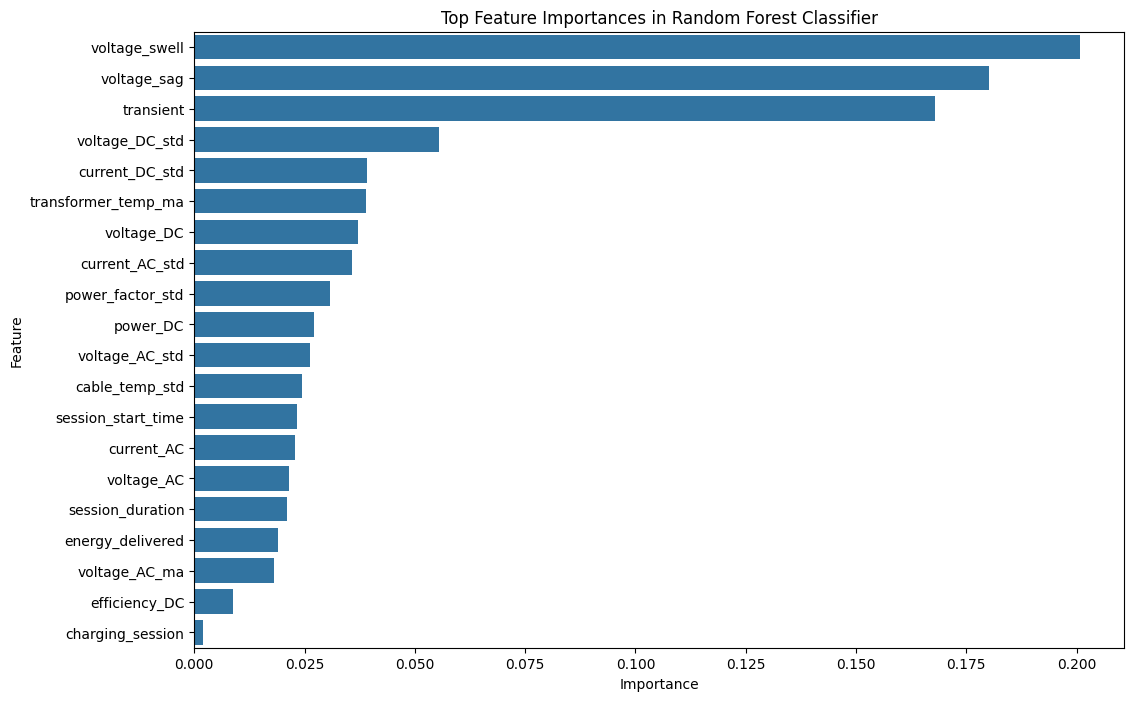

In [ ]:
# Feature Importance from Random Forest
importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features_classification,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20 features (if less than 20, display all)
top_n = min(20, feature_importance_df.shape[0])

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
plt.title('Top Feature Importances in Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
